In [15]:
import numpy as np
import scipy as sci
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from scipy.special import ellipj, ellipk

In [16]:
batch_size = 50
weight_decay = 0
learning_rate = 1e-3
number_epochs = 3000

In [17]:
def set_seed(seed=3):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [40]:
def create_data(tmax=20, dt=1, theta0=1.6): # theta0 is the initial angle of the pendulum in radians

    time_pts = np.arange(0, tmax, dt)

    # Calculate sine of half the initial angle
    S = np.sin(0.5 * theta0)

    # Compute the complete elliptic integral of the first kind
    K_S = ellipk(S**2)

    # Define the natural frequency based on the gravitational acceleration (approx. 9.81 m/s^2)
    omega_0 = np.sqrt(9.81)

    # Compute the Jacobian elliptic functions
    sn, cn, dn, ph = ellipj(K_S - omega_0 * time_pts, S**2)

    # Calculate the pendulum's angle theta at each time point
    theta = 2.0 * np.arcsin(S * sn)

    # Compute the derivative of sn with respect to its parameter
    d_sn_du = cn * dn

    # Convert the derivative with respect to the parameter to a time derivative
    d_sn_dt = -omega_0 * d_sn_du

    # Calculate the angular velocity of the pendulum at each time point
    d_theta_dt = 2.0 * S * d_sn_dt / np.sqrt(1.0 - (S * sn)**2)

    # Combine the angle and angular velocity into a single array and return it
    return np.stack([theta, d_theta_dt], axis=1)


In [38]:
def create_dataloader(x, batch_size=batch_size):
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(np.asarray(x[0:-1]), dtype=torch.double),
        torch.tensor(np.asarray(x[1::]), dtype=torch.double),
    )

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    dataset = torch.utils.data.TensorDataset(
        torch.tensor(np.asarray(x[0:-1]), dtype=torch.double),
        torch.tensor(np.asarray(x[1::]), dtype=torch.double),
    )

    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [20]:
def euler_step_func(f, x, dt):
    k1 = f(x)  # Calculate the derivative using the provided function f, dy/dx = f
    x_out = x + dt * k1  # Update the value of x, dt is the step size
    return x_out

In [21]:
def rk4_step_func(f, x, dt):
    k1 = f(x)                 # k1 is the slope of current point(initial slope)
    x1 = x + 0.5 * dt * k1    # x1 first intermediate value
    k2 = f(x1)                # second intermediate slope
    x2 = x + 0.5 * dt * k2    # second intermediate value
    k3 = f(x2)
    x3 = x + dt * k3
    k4 = f(x3)
    x_out = x + dt * (1.0 / 6.0 * k1 + 1.0 / 3.0 * k2 + 1.0 / 3.0 * k3 + 1.0 / 6.0 * k4) #take a weighted average of 4 slopes
    return x_out

In [22]:
def shallow(in_dim, hidden, out_dim, Act=torch.nn.Tanh):
    return torch.nn.Sequential(
        torch.nn.Linear(in_dim, hidden),  # Input to hidden layer
        Act(),                            # Activation function
        torch.nn.Linear(hidden, out_dim), # Hidden to output layer
    )

In [23]:
class ShallowODE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, hidden=10, Act=torch.nn.Tanh):
        super(ShallowODE, self).__init__()
        self.net = shallow(in_dim, hidden, out_dim, Act=Act)

    def forward(self, x, h, dt, method='euler'):
        if method == 'euler':
            # Integrate using Euler's method
            # for i in range(int(dt/h)):
            x = euler_step_func(self.net, x, dt)
            return x
        elif method == 'rk4':
            # Integrate using RK4 method
            # for i in range(int(dt/h)):
            x = rk4_step_func(self.net, x, dt)
            return x

In [42]:
def train(ODEnet, train_loader, lr = learning_rate, wd = weight_decay, method = 'rk4', dt = 0.1):

    optimizer_ODEnet = optim.Adam(ODEnet.parameters(), lr=learning_rate, weight_decay=weight_decay) # Optimizer Initialization

    criterion = torch.nn.MSELoss() # Loss Function

    ode_loss_hist = [] # Loss History
    print('ODENet Training')
    for epoch in range(1, number_epochs): # Epoch Loop
        for batch_idx, (inputs, targets) in enumerate(train_loader): # Batch Loop
            optimizer_ODEnet.zero_grad() # Before parameters are updated, gradients are zeroed out
            outputs = ODEnet(inputs, h=dt, dt=dt, method=method) # Forward Pass
            loss = criterion(outputs, targets) # Loss Calculation
            loss.backward() #Backward Pass
            optimizer_ODEnet.step() # Optimizers update model parameters
            ode_loss_hist.append(loss.item())

        if epoch % 10 == 0: print(f'Epoch: {epoch}, Loss: {loss.item()}') # Print for every epoches

    return ODEnet, ode_loss_hist

(1000, 2)
ODENet Training
Epoch: 10, Loss: 0.030742425661989477
Epoch: 20, Loss: 0.01126247020817277
Epoch: 30, Loss: 0.005506542819679599
Epoch: 40, Loss: 0.002888094148769896
Epoch: 50, Loss: 0.0013902060673986324
Epoch: 60, Loss: 0.000585795981269479
Epoch: 70, Loss: 0.000233219816417359
Epoch: 80, Loss: 0.0001041631836855558
Epoch: 90, Loss: 5.604994844284807e-05
Epoch: 100, Loss: 3.391508639884605e-05
Epoch: 110, Loss: 2.1878691591512492e-05
Epoch: 120, Loss: 1.4746976224958607e-05
Epoch: 130, Loss: 1.027138122410228e-05
Epoch: 140, Loss: 7.335464562875055e-06
Epoch: 150, Loss: 5.3398937500757755e-06
Epoch: 160, Loss: 3.943738032705689e-06
Epoch: 170, Loss: 2.9443278069766012e-06
Epoch: 180, Loss: 2.2193321570827362e-06
Epoch: 190, Loss: 1.690940694876611e-06
Epoch: 200, Loss: 1.3059762883194276e-06
Epoch: 210, Loss: 1.0271942576657805e-06
Epoch: 220, Loss: 8.263084168321261e-07
Epoch: 230, Loss: 6.837197117825022e-07
Epoch: 240, Loss: 5.886386445124403e-07
Epoch: 250, Loss: 5.165

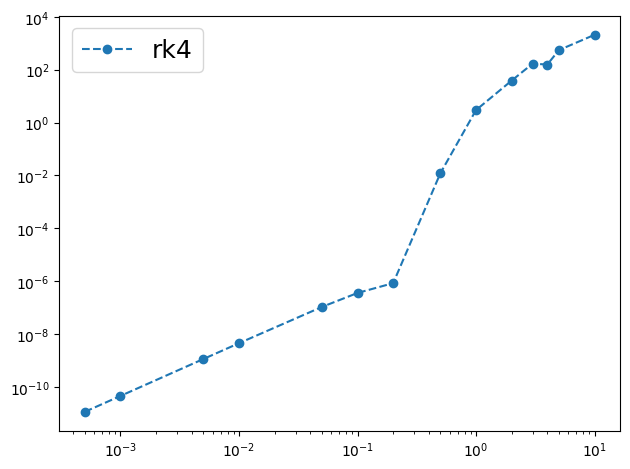

In [45]:
if __name__ == '__main__':
    dt = 0.2
    N_points = 1000
    T_MAX = N_points * dt
    x = create_data(tmax=T_MAX, dt=dt)
    print(x.shape)

    train_loader, test_loader = create_dataloader(x)
    integrator = 'rk4'
    hidden = 200

    set_seed(2024)
    ODEnet = ShallowODE(in_dim=2, hidden=hidden, out_dim=2, Act=torch.nn.Tanh).double()
    ODEnet, ode_loss_hist = train(ODEnet, train_loader, method=integrator, dt=dt)

    error = []

    # Evaluate the model --
    hs = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 10]

    for h in hs:
        T_MAX = N_points * dt
        x = create_data(tmax=T_MAX, dt=h)
        _, test_loader = create_dataloader(x)

        target_list = []
        output_list = []
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = ODEnet(inputs, h=h, dt=h, method=integrator)
            output_list.append(outputs.detach().numpy())
            target_list.append(targets.numpy())

        error.append(np.mean(np.linalg.norm(np.vstack(output_list)-np.vstack(target_list), axis=1)**2))

    error = np.vstack(error)


    plt.plot(hs, error, 'o--', label=integrator)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(fontsize=18)
    plt.tight_layout()

